In [45]:
import illustris_python as il
import matplotlib.pyplot as plt
import numpy as np
import h5py
import numba as nb
from numba import jit, njit
import tracerFuncs as tF
import locatingFuncs as lF
import illustrisFuncs as iF
import dm
import snapshot_mod as sm

import funcs
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib as mpl

import sys
sys.path.append('/vera/u/olwitt/illustris_python/illustris_python')
from loadMPBs import loadMPBs

plt.style.use('fancy_plots2.mplstyle')

## accretion channels

In [2]:
until = 87
run = 2
f = h5py.File(f'files/TNG50-{run}/accretion_channels_dm.hdf5','r')
mw_ids = f['subhalo_ids/subhalo_ids_mws'][:]
all_ids = f['subhalo_ids/all_subhalo_ids'][:]
inds = tF.getIndices(mw_ids, all_ids)
gal_comp = f['galaxy_composition'][:,inds,:]

mp = f['main_progenitor'][:until]
sub= f['all_galaxies'][:until]
igm = f['IGM'][:until]
# nums = f['binned_values'][:until,:,:]
total = f['totals'][:until]
z = f['redshift'][:until]
other_centrals = f['other_centrals'][:until]
mp_sat = f['satellites_of_main_progenitor'][:until]
satellites = f['satellites'][:until]
f.close()

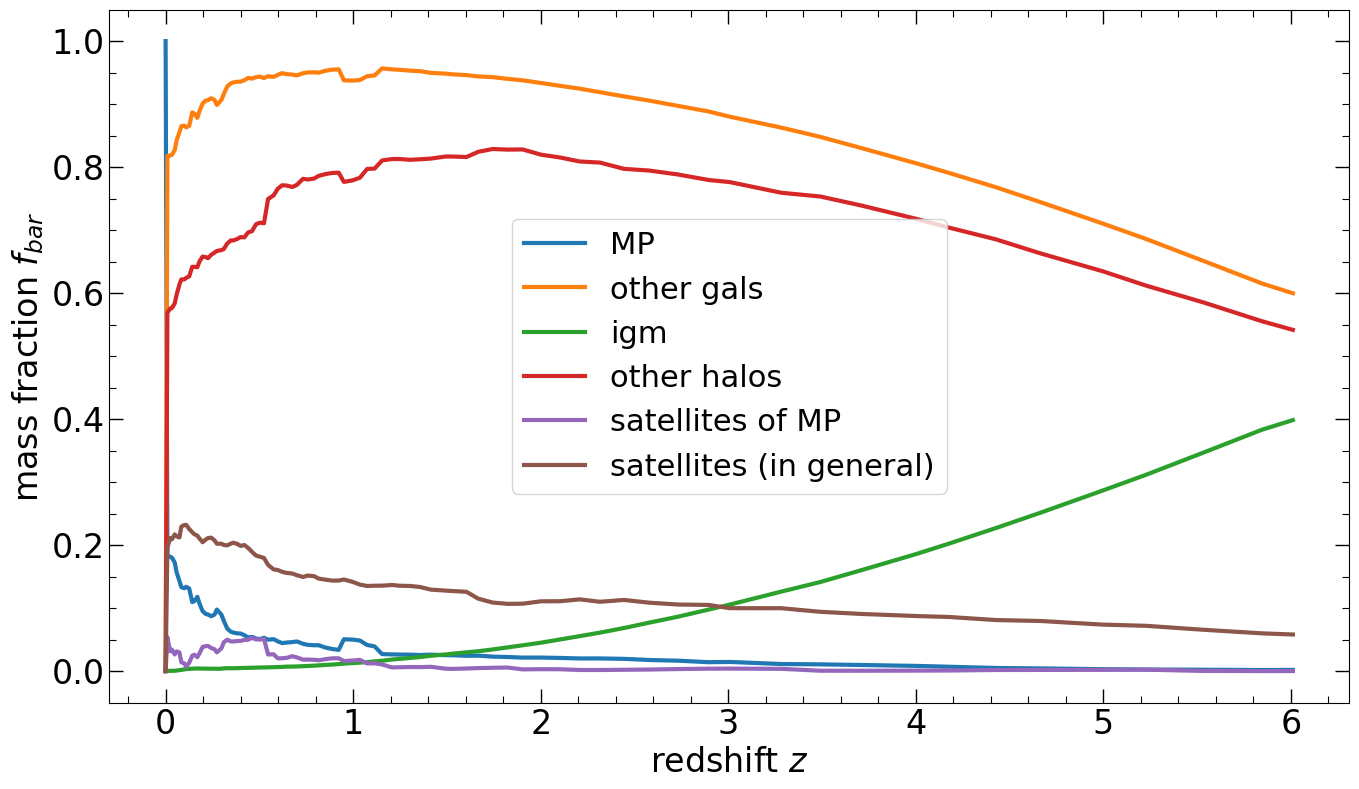

In [3]:
plt.plot(z,mp/total, label = 'MP')
plt.plot(z,sub/total, label = 'other gals')
plt.plot(z,igm/total, label = 'igm')
plt.plot(z,other_centrals/total,label = 'other halos')
plt.plot(z,mp_sat/total, label = 'satellites of MP')
plt.plot(z,satellites/total, label = 'satellites (in general)')
plt.legend()
plt.xlabel('redshift $z$')
plt.ylabel('mass fraction $f_{bar}$')
pass

In [2]:
basePath=f'/virgotng/universe/IllustrisTNG/TNG50-{run}/output'
h_const = il.groupcat.loadHeader(basePath, 99)['HubbleParam']
stellar_masses = il.groupcat.loadSubhalos(basePath, 99, fields = ['SubhaloMassType'])[:,4] * 1e10 / h_const

f = h5py.File('files/' + basePath[32:39] + '/accretion_channels_dm.hdf5','r')
# mw_ids = f['subhalo_ids/subhalo_ids_mws'][:]
all_ids = f['subhalo_ids/all_subhalo_ids'][:]
# inds = tF.getIndices(mw_ids, all_ids)
# gal_comp = f['galaxy_composition'][:,inds,:]

overall_fracs = f['accretion_channels/overall_fractions'][:]
print(overall_fracs)
gal_accretion_channels = f['accretion_channels/for_all_galaxies'][:,:]
print(gal_accretion_channels.shape)
print(all_ids.shape)
f.close()

stellar_masses = stellar_masses[all_ids]
print(np.where(stellar_masses == 0)[0])
mass_mask = np.nonzero(stellar_masses)[0]
stellar_masses = np.log10(stellar_masses[mass_mask])
gal_accretion_channels = gal_accretion_channels[mass_mask,:]
print(gal_accretion_channels.shape)

non_zero_mask = np.where(np.any(gal_accretion_channels[:,:] > 0, axis = 1))[0]
print(non_zero_mask.shape)
numBins = 15

mass_bins, from_igm_bins = funcs.binData_mean(stellar_masses[non_zero_mask],\
                                                       gal_accretion_channels[non_zero_mask,0], numBins)
_, from_other_halos_bins = funcs.binData_mean(stellar_masses[non_zero_mask],\
                                                       gal_accretion_channels[non_zero_mask,1], numBins)
_, mergers_bins = funcs.binData_mean(stellar_masses[non_zero_mask],\
                                                       gal_accretion_channels[non_zero_mask,2], numBins)
_, stripped_from_halos_bins = funcs.binData_mean(stellar_masses[non_zero_mask],\
                                                       gal_accretion_channels[non_zero_mask,3], numBins)
_, wind_recycle_bins = funcs.binData_mean(stellar_masses[non_zero_mask],\
                                                       gal_accretion_channels[non_zero_mask,4], numBins)
_, nep_wind_recycle_bins = funcs.binData_mean(stellar_masses[non_zero_mask],\
                                                       gal_accretion_channels[non_zero_mask,5], numBins)

NameError: name 'run' is not defined

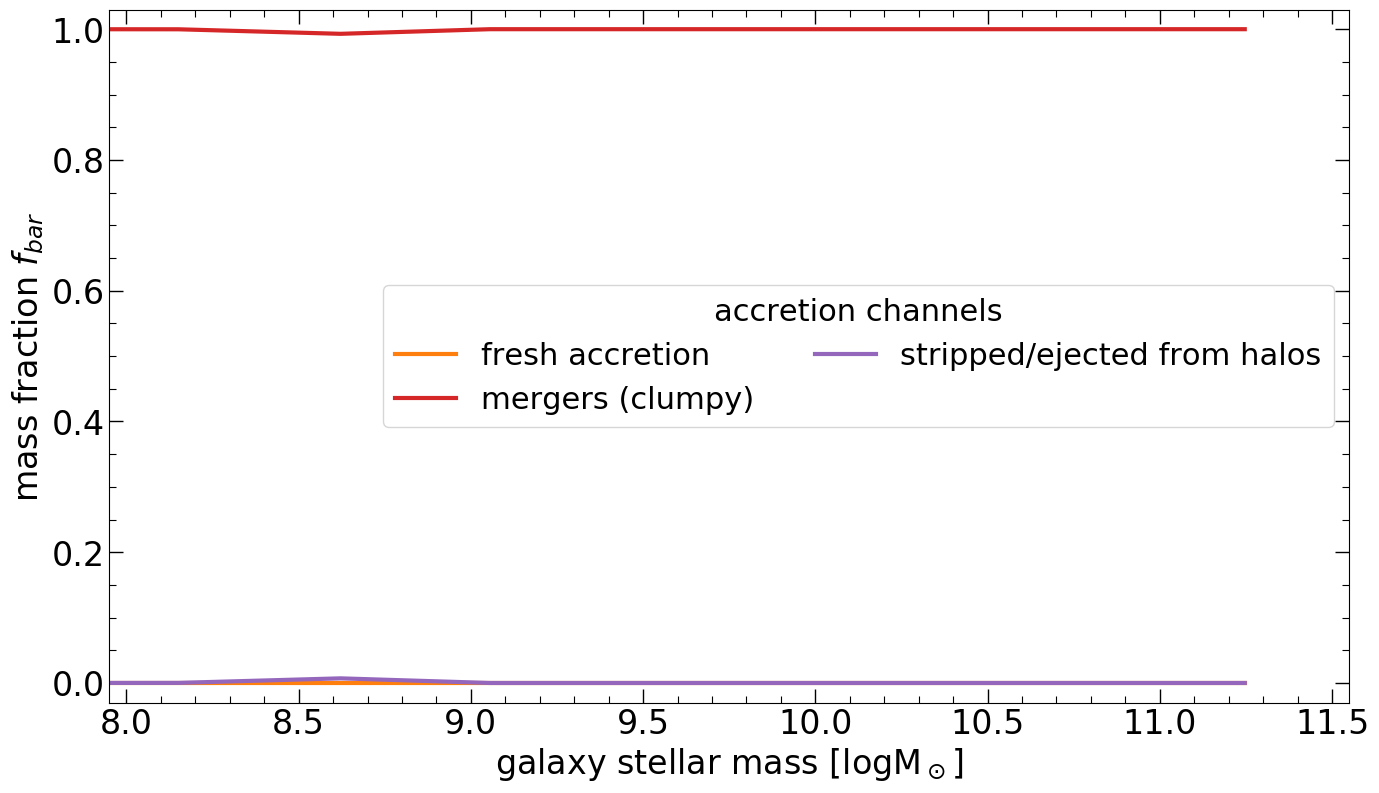

In [5]:
plt.plot(mass_bins, from_igm_bins - nep_wind_recycle_bins,label = 'fresh accretion', color = 'tab:orange')
# plt.plot(mass_bins, nep_wind_recycle_bins, color = 'tab:green', label = 'wind recycled (in MP, NEP)')
plt.plot(mass_bins, mergers_bins, color = 'tab:red', label = 'mergers (clumpy)')
plt.plot(mass_bins, stripped_from_halos_bins, color = 'tab:purple', label = 'stripped/ejected from halos')

plt.legend(title = 'accretion channels', fontsize = 22, ncol = 2)
plt.xlabel(r'galaxy stellar mass [$\log \rm{M}_\odot$]')
plt.ylabel('mass fraction $f_{bar}$')
plt.xlim(7.95,11.55)

plt.ylim(-0.03,1.03)
# plt.savefig(f'pics/accretion_channels/accretion_50-{run}_dm.pdf', format = 'pdf')
plt.show()

## dm halo core formation times

In [3]:
run = 2
basePath = f'/virgotng/universe/IllustrisTNG/TNG50-{run}/output'
f = h5py.File(f'/vera/ptmp/gc/olwitt/dm/TNG50-{run}/core_fractions/core_fractions_99.hdf5', 'r')
core_frac_99 = f['core_fractions_2SHMR_99'][:]
subhaloFlag = f['subhaloFlag_99'][:]
print(np.nonzero(core_frac_99)[0].shape[0])
print(core_frac_99.shape[0])
print(np.nonzero(subhaloFlag)[0].shape[0])
f.close()

30728
859077
782434


0.7574413726158526


Text(0, 0.5, 'core fraction')

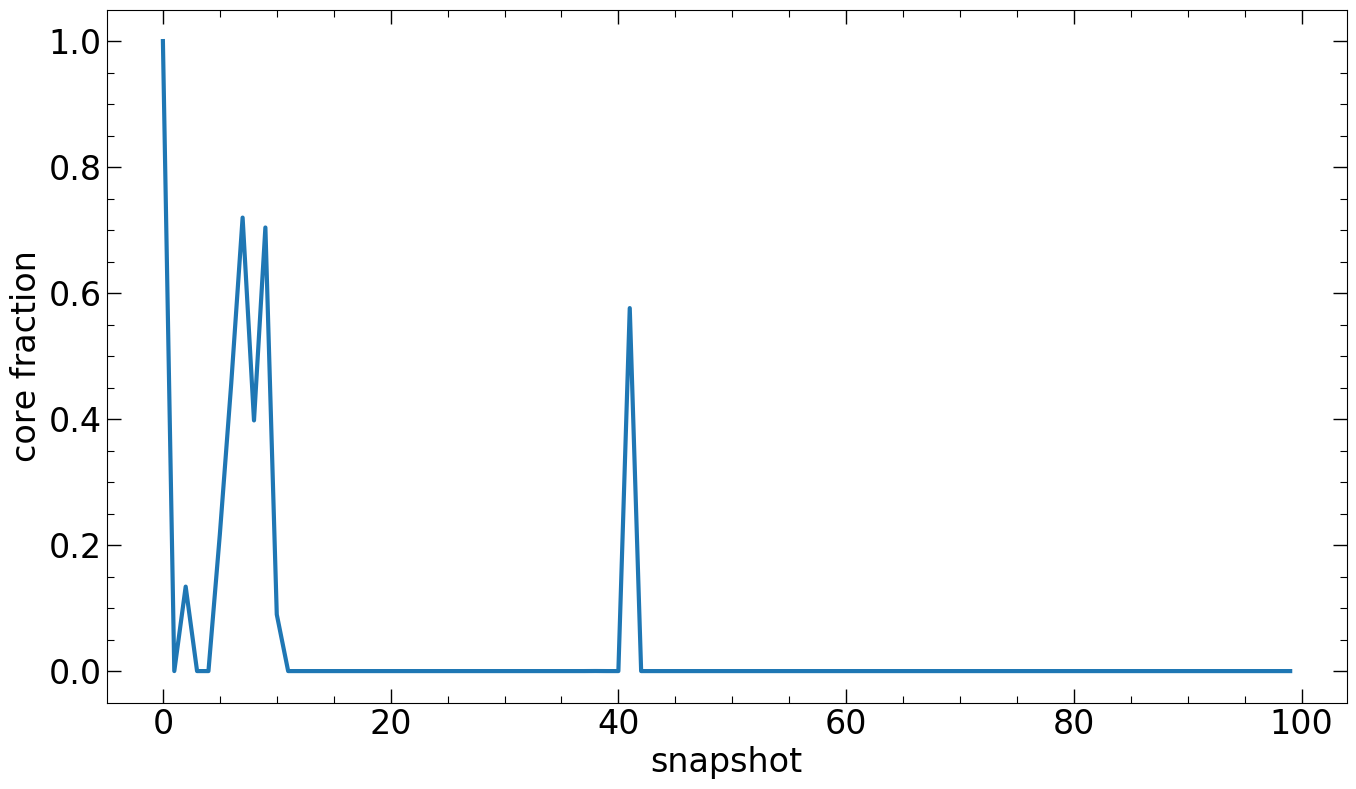

In [12]:
run = 2
basePath = f'/virgotng/universe/IllustrisTNG/TNG50-{run}/output'
test = np.zeros(100)
sub_id = 10
for snap in range(99,-1,-1):
    f = h5py.File(f'/vera/ptmp/gc/olwitt/dm/TNG50-{run}/core_fractions/core_fractions_{snap}.hdf5', 'r')
    core_frac = f[f'core_fractions_2SHMR_{snap}'][:]
    
    test[99-snap] = core_frac[sub_id]
    f.close()

f = h5py.File('files/' + basePath[32:39] + '/dm_halo_core_formation_times.hdf5','r')
core_form_z = f['core_formation_times'][:]
print(core_form_z[sub_id])
f.close()

snaps = np.arange(100)
plt.plot(snaps, test)
plt.xlabel('snapshot')
plt.ylabel('core fraction')

In [26]:
run = 4
basePath = f'/virgotng/universe/IllustrisTNG/TNG50-{run}/output'
h_const = il.groupcat.loadHeader(basePath, 99)['HubbleParam']
stellar_masses = il.groupcat.loadSubhalos(basePath, 99, fields = ['SubhaloMassType'])[:,4] * 1e10 / h_const
groups = il.groupcat.loadHalos(basePath, 99, fields = ['Group_M_Crit200','GroupFirstSub'])
group_masses = groups['Group_M_Crit200'] * 1e10 / h_const
gfs = groups['GroupFirstSub']
f = h5py.File('files/' + basePath[32:39] + '/dm_halo_core_formation_times.hdf5','r')
core_form_z = f['core_formation_times'][:]
subhaloFlag = f['subhaloFlag'][:]
form_z = f['formation_times'][:]
central_subhaloFlag = f['central_subhaloFlag'][:]
f.close()

In [27]:
print(np.nonzero(subhaloFlag)[0].shape)
print(subhaloFlag.shape)

(1508,)
(22869,)


In [11]:
mask = np.where(stellar_masses > 0)[0]
log_masses = np.log10(stellar_masses[mask])
core_form_z = core_form_z[mask]
subhaloFlag = subhaloFlag[mask]
good_indices = np.where(np.logical_and(subhaloFlag == 1, core_form_z > 0))[0]

In [28]:
_, GFS_inds, _ = np.intersect1d(gfs, np.nonzero(central_subhaloFlag)[0], return_indices = True)
imp_group_masses = group_masses[GFS_inds]
imp_form_z = form_z[np.nonzero(central_subhaloFlag)[0]]
mask = np.where(imp_group_masses > 0)[0]
print(mask)
log_masses = np.log10(imp_group_masses[mask])
imp_form_z = form_z[mask]
imp_central_subhaloFlag = central_subhaloFlag[mask]
good_indices = np.where(np.logical_and(imp_central_subhaloFlag == 1, imp_form_z > 0))[0]

[0]


In [29]:
xmed,ymed = funcs.binData_mean(log_masses[good_indices], form_z[good_indices],10)

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
print(np.nonzero(form_z[good_indices])[0].shape[0])
print(good_indices.shape[0])

In [19]:
print(GFS_inds)
print(np.nonzero(central_subhaloFlag)[0].shape[0])

[ 33462  46649  76540 162556 560417 594973 843675]
184680


[20.04649099         nan         nan         nan 20.04649099         nan
         nan         nan         nan         nan]


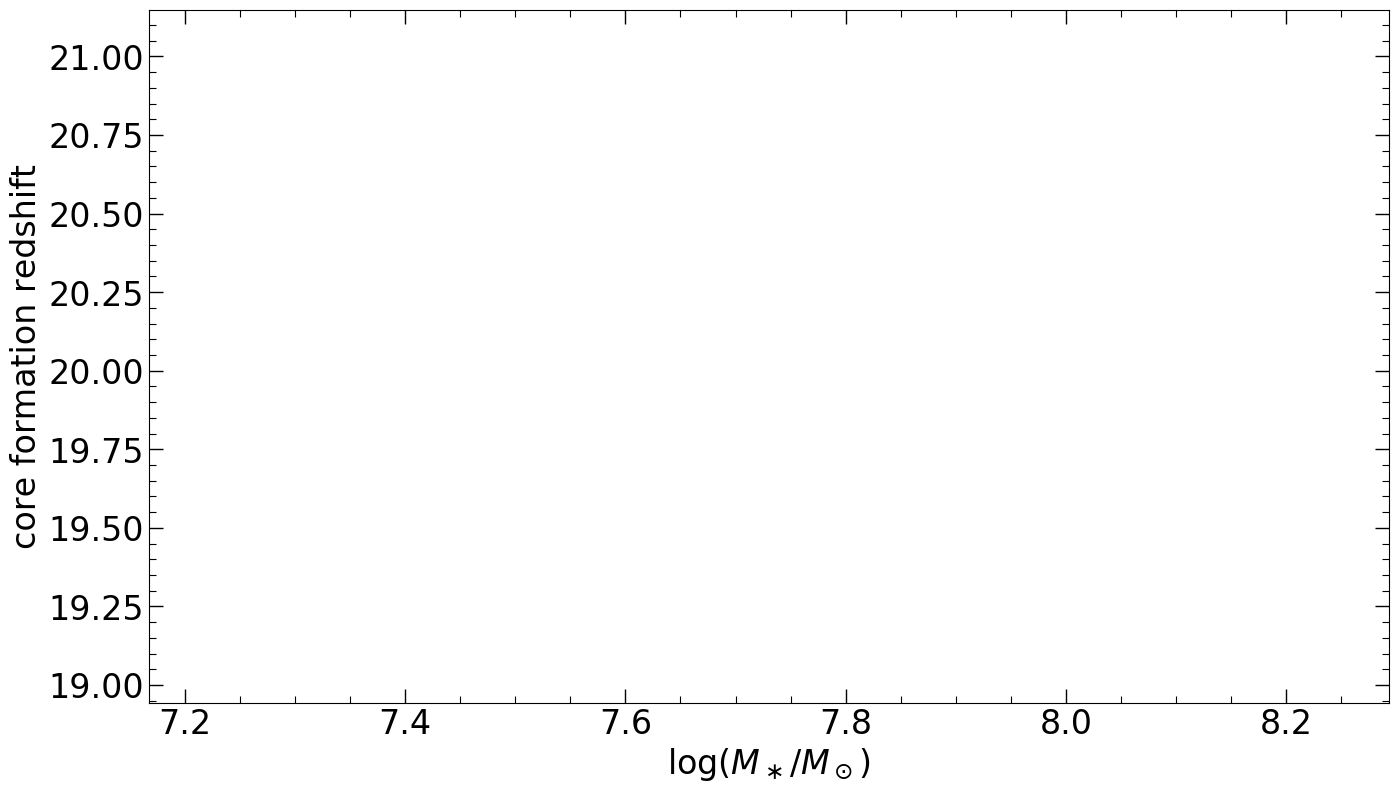

In [15]:
plt.plot(xmed, ymed)
plt.xlabel(r'log($M_\ast$/$M_\odot$)')
plt.ylabel('core formation redshift')
print(ymed)

## trajectories of 10 DM particles

In [74]:
run = 1
basePath = f'/virgotng/universe/IllustrisTNG/TNG50-{run}/output'
boxSize = il.groupcat.loadHeader(basePath, 99)['BoxSize']

sub_id = 10
tree = il.sublink.loadTree(basePath, 99, sub_id, fields = ['SubhaloPos', 'SubhaloHalfmassRadType', 'SubfindID'])
inds = np.array([0,200,50,4000,3678, 999, 73, 826, 1234, 2008])
rel_coord = np.zeros((inds.shape[0],20,3))

snaps = np.arange(99,79,-1)

for i, snap in enumerate(snaps):
    sub_id = tree['SubfindID'][99-snap]
    particle_pos = il.snapshot.loadSubhalo(basePath, snap, sub_id, 'dm', fields = ['Coordinates'])[inds,:]
    
    subhaloPos = tree['SubhaloPos'][99 - snap][:]
    shmr = tree['SubhaloHalfmassRadType'][99 - snap][4]
    
    diff = particle_pos - subhaloPos
    diff[np.where(diff>boxSize/2)[0]] -= boxSize
    diff[np.where(diff<=-boxSize/2)[0]] += boxSize
    
    rel_coord[:,i,:] = diff / shmr

Text(0, 0.5, 'y [$R_{0.5,\\ast}$]')

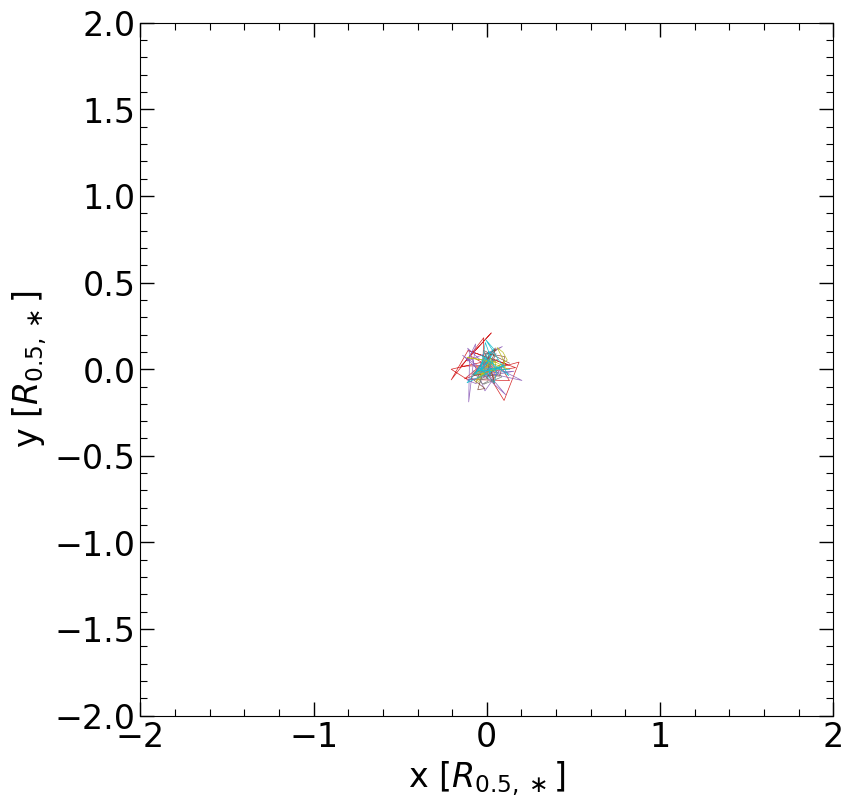

In [75]:
fig, ax = plt.subplots()
for i in range(10):
    plt.plot(rel_coord[i,:,0], rel_coord[i,:,1], linewidth = 0.5)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.gca().set_aspect('equal')

plt.xlabel(r'x [$R_{0.5, \ast}$]')
plt.ylabel(r'y [$R_{0.5,\ast}$]')

## dm halo core formation times vol. 2

In [85]:
#try lagrangian region times computation:
run = 2
basePath=f'/virgotng/universe/IllustrisTNG/TNG50-{run}/output'
stype = 'dm'
target_snap = 99
file = f'/vera/ptmp/gc/olwitt/auxCats/TNG50-{run}/dm_halo_core_formation_times.hdf5'
f = h5py.File(file,'r')
form_z = f['formation_times'][:]
subhaloFlag = f['subhaloFlag'][:]
f.close()
print(np.nonzero(subhaloFlag)[0].shape)

h_const = il.groupcat.loadHeader(basePath, 99)['HubbleParam']
stellar_masses = il.groupcat.loadSubhalos(basePath, 99, fields = ['SubhaloMassType'])[:,4] * 1e10 / h_const

stellar_masses = stellar_masses[np.nonzero(subhaloFlag)]
form_z = form_z[np.nonzero(subhaloFlag)]


mask = np.where(np.logical_and(stellar_masses > 0, form_z != -1))[0]
stellar_masses = np.log10(stellar_masses[mask])

numBins = 15

mass_bins, form_z_bins = funcs.binData_mean(stellar_masses, form_z[mask], numBins)

(15461,)


In [86]:
print(form_z_bins)

[3.03907843e-03 6.60601782e-04 2.86465710e-03 1.72782649e-03
 3.74446725e-03 2.27318071e-03 6.26463506e-03 1.35730258e-03
 1.05037881e-02 2.30837446e-02 2.67285016e-02 7.92027429e-02
 3.56056171e-01 2.22044605e-16            nan]


(7, 12)

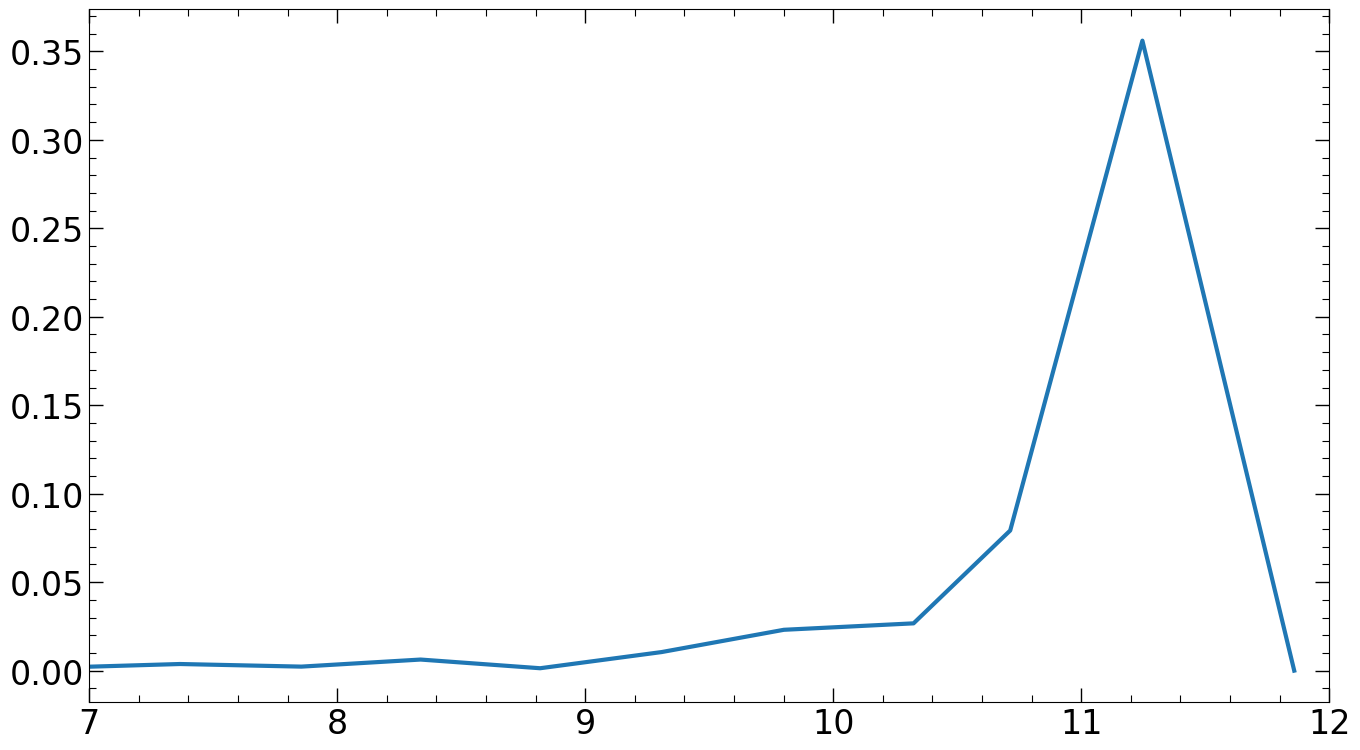

In [88]:
plt.plot(mass_bins, form_z_bins)
plt.xlim(7,12)

In [66]:
run = 2
basePath = f'/virgotng/universe/IllustrisTNG/TNG50-{run}/output'
test = np.zeros(100)
sub_id = 10482
for snap in range(99,-1,-1):
    f = h5py.File(f'/vera/ptmp/gc/olwitt/dm/TNG50-{run}/lagrangian_regions/lagrangian_regions_cut21_{snap}.hdf5', 'r')
    sub_med_dist = f[f'lagrangian_regions_shmr'][:,:]
    
    test[99-snap] = sub_med_dist[sub_id,0]
    f.close()

file = f'/vera/ptmp/gc/olwitt/auxCats/TNG50-{run}/dm_halo_core_formation_times.hdf5'
f = h5py.File(file,'r')
form_z = f['core_formation_times'][:]
subhaloFlag = f['subhaloFlag'][:]
f.close()
print(form_z[sub_id])

0.12575933241126092


In [68]:
t = funcs.data_intersect_value(test,2)
print(t)

(array([10]), True)


[1.22989566e+00 1.79878845e+00 1.67171684e+00 1.47082084e+00
 1.71026274e+00 1.77729916e+00 1.87815223e+00 1.83586945e+00
 1.55116565e+00 1.69017211e+00 1.99317400e+00 2.55922659e+00
 2.80036265e+00 3.09483485e+00 3.32819203e+00 3.65374457e+00
 3.83390956e+00 3.97167940e+00 3.53681982e+00 4.24410080e+00
 4.91614578e+00 5.45373276e+00 5.47985290e+00 5.59668145e+00
 6.47709499e+00 6.50215617e+00 6.75300716e+00 6.67353779e+00
 6.82255219e+00 7.57829583e+00 7.76644276e+00 7.93964276e+00
 9.19022866e+00 9.17222780e+00 9.64246093e+00 1.22873767e+01
 2.59611838e+01 3.26338973e+01 3.65317553e+01 1.76769036e+01
 4.93080665e+01 5.94997913e+01 7.13250309e+01 8.49586760e+01
 6.26050438e+02 6.30433657e+02 6.15821331e+02 6.13387530e+02
 3.83530942e+00 3.82511402e+00 4.54243591e+00 1.24279859e+01
 1.77221503e+01 6.23107398e+02 1.22929571e+03 1.27150942e+03
 1.24828870e+03 1.30399302e+03 1.31334592e+03 1.11790545e+03
 1.22934627e+03 1.37302454e+03 2.05164021e+03 2.08581742e+03
 2.25662025e+03 1.865081

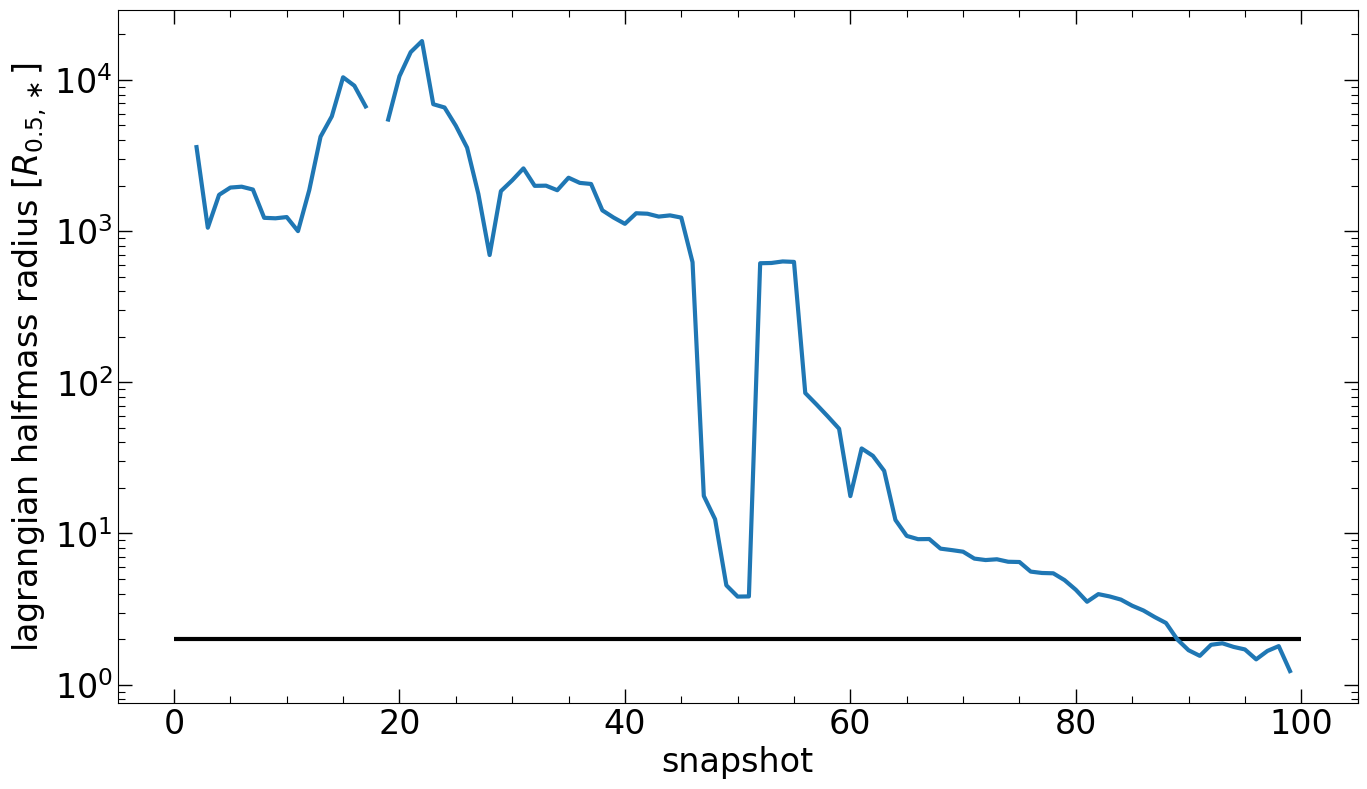

In [69]:
snaps = np.arange(99,-1,-1)
print(test)
plt.plot(snaps, test)
plt.hlines(2,0,100)
plt.xlabel('snapshot')
plt.ylabel(r'lagrangian halfmass radius [$R_{0.5,\ast}$]')
plt.yscale('log')

## check how fast DM particles are moving

In [114]:
run = 3
basePath=f'/virgotng/universe/IllustrisTNG/TNG50-{run}/output'
sub0 = il.snapshot.loadSubhalo(basePath, 99, 0, 'dm', fields = ['Velocities'])
sub0 = np.linalg.norm(sub0, axis = 1)
sub = il.groupcat.loadSingle(basePath, 99, haloID = 0)
sub_mass = sub['Group_M_Crit200'] * 1e10 * 1e30 #solar masses * 1e30 kg/solar mass
sub_rad = sub['Group_R_Crit200'] * 1000 * 3.1e16
sub_vel = np.sqrt(sub_mass * 6.67e-13 / sub_rad) / 1000
print(sub_vel)

57.15117607671902


Text(0.5, 0, 'velocity [V/V_200]')

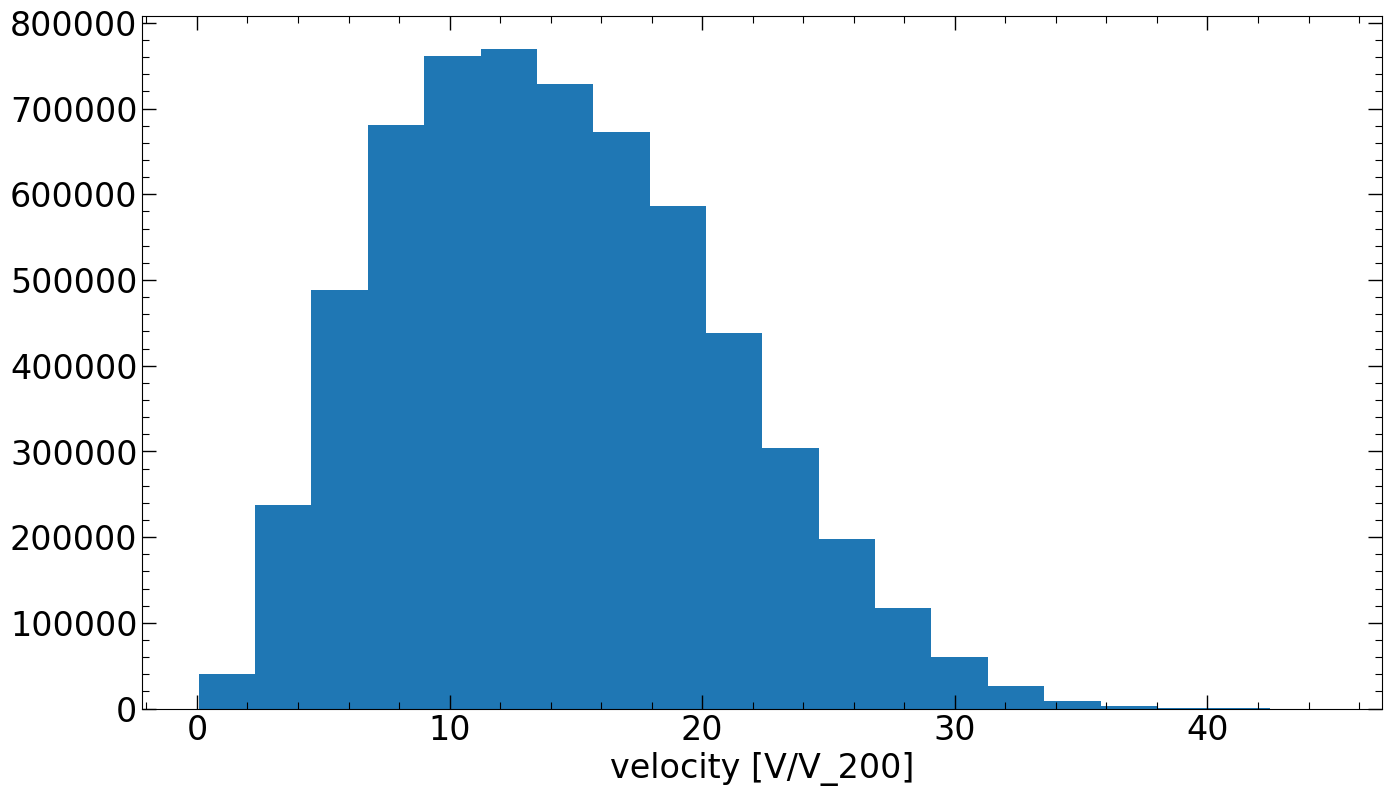

In [115]:
plt.hist(sub0/sub_vel, bins = 20)
plt.xlabel('velocity [V/V_200]')

In [118]:
central = il.groupcat.loadSingle(basePath, 99, subhaloID = 0)
h_const = il.groupcat.loadHeader(basePath, 99)['HubbleParam']
central_shmr = central['SubhaloHalfmassRadType'][4] / h_const * 1000 * 3.1e13

In [119]:
print(central_shmr)

2.0643736459457805e+18


In [122]:
central_shmr*2/(12*sub_vel) / 3.14e7 #yr until radius reached
#-> ~100Myrs

95863270.2218179